# Elternleben.de Chatbot Hackathon - Data Exploration

This notebook provides exploratory data analysis for the Elternleben.de Chatbot Hackathon. Use this as a starting point to understand the dataset structure and identify patterns that will inform your chatbot design.

## 1. Setup and Data Loading

First, let's import the necessary libraries and load our datasets.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from pathlib import Path
from datetime import datetime
from collections import Counter
import networkx as nx
from wordcloud import WordCloud
from markdown import markdown
from bs4 import BeautifulSoup

# Set better visualization defaults
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Load metadata
metadata_df = pd.read_csv('metadata.csv')

# Load conversation data
conversations_df = pd.read_csv('processed_conversations.csv')

# Display basic information
print(f"Content metadata: {len(metadata_df)} articles")
print(f"Conversation logs: {len(conversations_df)} messages in {conversations_df['conversation_id'].nunique()} conversations")

# Preview metadata
metadata_df.head()

Content metadata: 8080 articles
Conversation logs: 253 messages in 135 conversations


,url,filepath,filename,title,description,author,category,content_type,crawled_at
0,https://www.elternleben.de/angebote-vor-ort/da...,elternleben/angebote-vor-ort/das-patenprojekt-...,das-patenprojekt-berlin-ev.md,das patenprojekt berlin e.V.,das patenprojekt berlin e.V. ist ein Verein in...,NaN,elternleben,NaN,2025-03-04T10:07:32.311761
1,https://www.elternleben.de/angebote-vor-ort/ka...,elternleben/angebote-vor-ort/kath-beratungsste...,kath-beratungsstelle-fuer-ehe-familien-und-leb...,"Kath. Beratungsstelle für Ehe-, Familien- und ...",Angebote in Euskirchen: Paarberatung,NaN,elternleben,NaN,2025-03-04T10:07:32.592258
2,https://www.elternleben.de/angebote-vor-ort/ki...,elternleben/angebote-vor-ort/kinderarztpraxis-...,kinderarztpraxis-dr-med-ines-tiedemann.md,Kinderarztpraxis Dr. med. Ines Tiedemann,Angebote in Wiefelstede: Kinder- und Jugendarzt,NaN,elternleben,NaN,2025-03-04T10:07:32.855380
3,https://www.elternleben.de/angebote-vor-ort/in...,elternleben/angebote-vor-ort/integrative-erzie...,integrative-erziehungs-und-familienberatungsst...,Integrative Erziehungs- und Familienberatungss...,Angebote in Sondershausen: Schwangerschaftsber...,NaN,elternleben,NaN,2025-03-04T10:07:33.128457
4,https://www.elternleben.de/angebote-vor-ort/sk...,elternleben/angebote-vor-ort/skf-sozialdienst-...,-schwangerschaftsberatung.md,SkF-Sozialdienst kath. Frauen e.V. / Schwanger...,Angebote in Vechta: Schwangerschaftsberatung,NaN,elternleben,NaN,2025-03-04T10:07:33.420316


In [34]:

# Extract filename from filepath and create a new column with just the path
metadata_df['path'] = metadata_df['filepath'].apply(lambda x: os.path.dirname(x) if pd.notna(x) else np.nan)

# Calculate path depth (number of subdirectories)
metadata_df['path_depth'] = metadata_df['path'].apply(
    lambda x: len(x.split('/')) if pd.notna(x) else 0
)

# Remove rows containing 'angebote-vor-ort' in the path
metadata_df = metadata_df[~metadata_df['path'].str.contains('angebote-vor-ort', na=False)]

# Recalculate path depth after filtering
metadata_df['path_depth'] = metadata_df['path'].apply(
    lambda x: len(x.split('/')) if pd.notna(x) else 0
)

# Reset the index of the DataFrame after filtering
metadata_df = metadata_df.reset_index(drop=True)

# Extract category from filepath
# The category is typically the first part of the path
metadata_df['derived_category'] = metadata_df['filepath'].apply(
    lambda x: x.split('/')[1] if pd.notna(x) and '/' in x else np.nan
)

# Compare with existing category field
category_match = (metadata_df['category'] == metadata_df['derived_category']).mean() * 100
print(f"Category match percentage: {category_match:.2f}%")

# Check for discrepancies between derived and existing categories
discrepancy_df = metadata_df[metadata_df['category'] != metadata_df['derived_category']]
if not discrepancy_df.empty:
    print(f"\nFound {len(discrepancy_df)} discrepancies between derived and existing categories")
    print(discrepancy_df[['filepath', 'category', 'derived_category']].head())

# Use derived category if original is missing
metadata_df['category'] = metadata_df.apply(
    lambda row: row['derived_category'] if pd.isna(row['category']) else row['category'], 
    axis=1
)




# Display the first few rows to verify the extraction
print("Filepath extraction example:")
sample_df = metadata_df[['filepath', 'path']].head()
print(sample_df)

# Count the number of files in each directory path
path_counts = metadata_df['path'].value_counts()
print(f"\nTop 10 directories by content count:")
print(path_counts.head(10))

# Calculate the depth of each path (number of subdirectories)
metadata_df['path_depth'] = metadata_df['path'].apply(
    lambda x: len(x.split('/')) if pd.notna(x) else 0
)

# Summarize path depths
print(f"\nPath depth distribution:")
print(metadata_df['path_depth'].value_counts().sort_index())

display(metadata_df.head())


Category match percentage: 0.00%

Found 770 discrepancies between derived and existing categories
                                            filepath     category  \
0            elternleben/baby/wachstumsschub-baby.md  elternleben   
1  elternleben/familie-und-partnerschaft/beruf/fa...  elternleben   
2  elternleben/elternwissen/kleinkind/gesundheit-...  elternleben   
3             elternleben/shop/handbuch-fruehchen.md  elternleben   
4  elternleben/schwangerschaft/gesunde-schwangers...  elternleben   

            derived_category  
0                       baby  
1  familie-und-partnerschaft  
2               elternwissen  
3                       shop  
4            schwangerschaft  
Filepath extraction example:
                                            filepath  \
0            elternleben/baby/wachstumsschub-baby.md   
1  elternleben/familie-und-partnerschaft/beruf/fa...   
2  elternleben/elternwissen/kleinkind/gesundheit-...   
3             elternleben/shop/handbuch-fruehche

,url,filepath,filename,title,description,author,category,content_type,crawled_at,path,path_depth,derived_category
0,https://www.elternleben.de/baby/wachstumsschub...,elternleben/baby/wachstumsschub-baby.md,wachstumsschub-baby.md,Wachstumsschub beim Baby: Wichtige Infos zu je...,Dein Baby wächst! Hier erfährst du alles zu de...,NaN,elternleben,NaN,2025-03-04T10:07:46.870180,elternleben/baby,2,baby
1,https://www.elternleben.de/familie-und-partner...,elternleben/familie-und-partnerschaft/beruf/fa...,familie-und-beruf-vaeter-wuenschen-sich-verein...,Familie und Beruf – Väter wünschen sich Verein...,"Vor welchen Fragen stehen Väter, die sich eine...",NaN,elternleben,NaN,2025-03-04T10:07:48.215121,elternleben/familie-und-partnerschaft/beruf,3,familie-und-partnerschaft
2,https://www.elternleben.de/elternwissen/kleink...,elternleben/elternwissen/kleinkind/gesundheit-...,gesundheit-und-ernaehrung.md,Gesundheit und Ernährung,NaN,NaN,elternleben,NaN,2025-03-04T10:07:48.798843,elternleben/elternwissen/kleinkind,3,elternwissen
3,https://www.elternleben.de/shop/handbuch-frueh...,elternleben/shop/handbuch-fruehchen.md,handbuch-fruehchen.md,Handbuch Frühchen,"Hier erfährst du unter anderem, wie du als Mut...",NaN,elternleben,NaN,2025-03-04T10:07:52.916329,elternleben/shop,2,shop
4,https://www.elternleben.de/schwangerschaft/ges...,elternleben/schwangerschaft/gesunde-schwangers...,untersuchungen.md,Meine wichtigsten ärztlichen Untersuchungen in...,Vorsorgeuntersuchung in der Schwangerschaft: E...,NaN,elternleben,NaN,2025-03-04T10:07:55.040650,elternleben/schwangerschaft/gesunde-schwangers...,3,schwangerschaft


## 2. Content Distribution Analysis

Let's explore how content is distributed across categories and types.

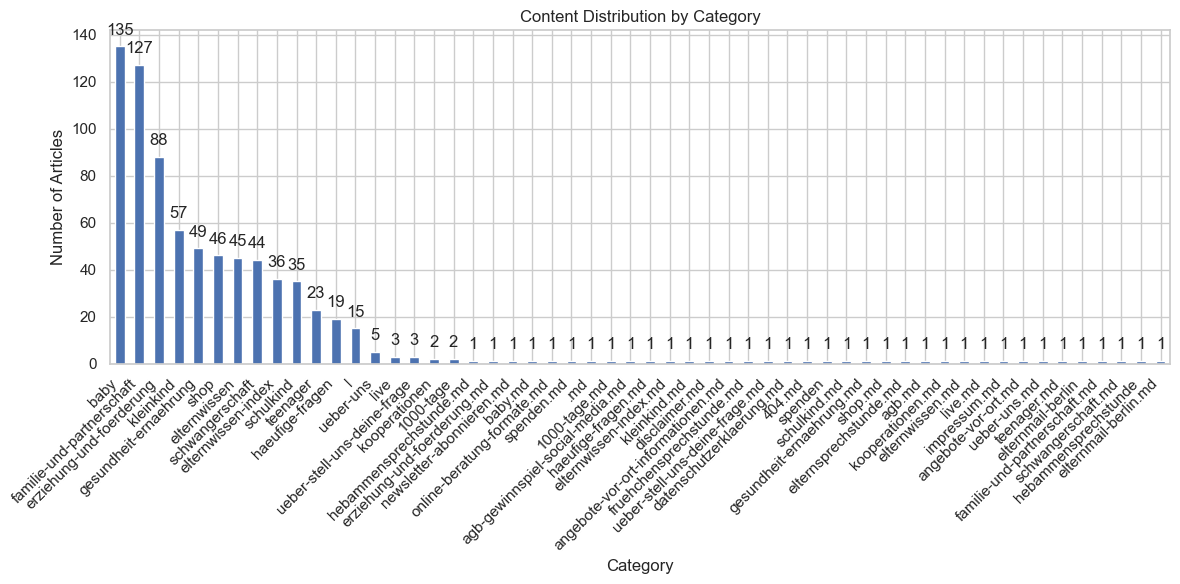

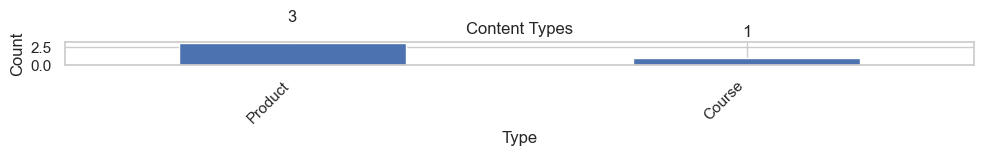

In [35]:
# Analyze content distribution by category
plt.figure(figsize=(12, 6))
category_counts = metadata_df['derived_category'].value_counts()
ax = category_counts.plot(kind='bar')
plt.title('Content Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')

# Add count labels on bars
for i, count in enumerate(category_counts):
    ax.text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

# Distribution by content type
plt.figure(figsize=(10, 5))
content_types = metadata_df['content_type'].value_counts()
ax = content_types.plot(kind='bar')
plt.title('Content Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

# Add count labels
for i, count in enumerate(content_types):
    ax.text(i, count + 3, str(count), ha='center')

plt.tight_layout()
plt.show()

## 3. Analyzing Content Relationships

Let's explore the hierarchical structure of the content to understand topic relationships.

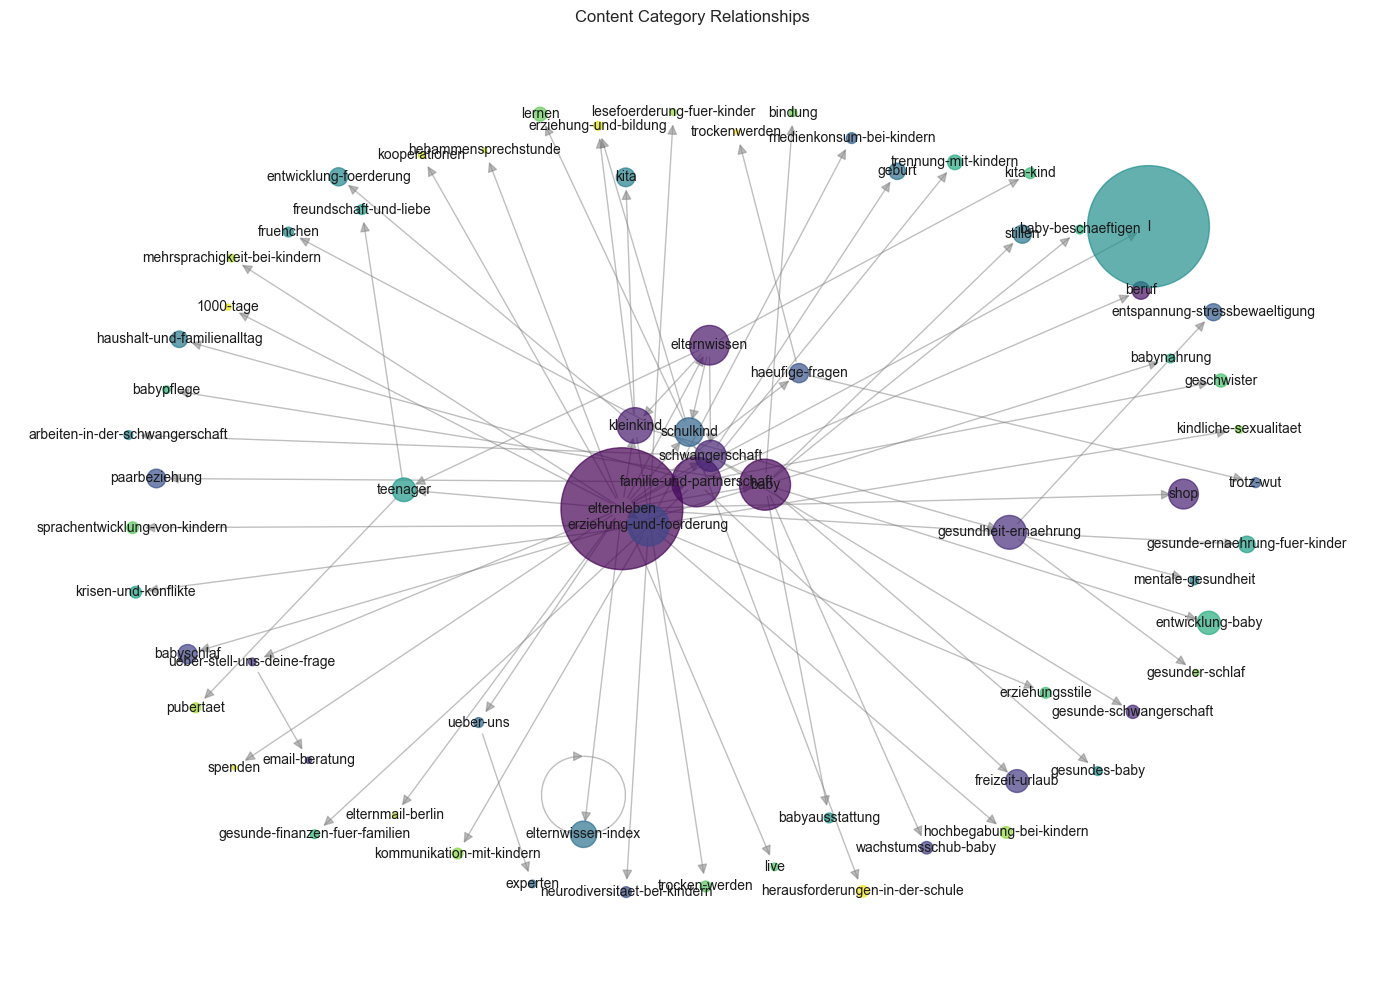

Top-level categories:
elternleben: 770 articles, 21 subcategories


In [36]:
# Extract category hierarchy from filepaths
def extract_category_path(filepath):
    if pd.isna(filepath):
        return []
    parts = filepath.split('/')
    return [p for p in parts if p]

# Create a directed graph of content categories
G = nx.DiGraph()

# Add nodes and edges based on filepaths
for _, row in metadata_df.iterrows():
    if pd.isna(row['path']):
        continue
        
    path_parts = extract_category_path(row['path'])
    
    # Skip if no valid path
    if not path_parts:
        continue
    
    # Add nodes and edges to represent the hierarchy
    for i in range(len(path_parts) - 1):
        parent = path_parts[i]
        child = path_parts[i + 1]
        
        # Add nodes if they don't exist
        if not G.has_node(parent):
            G.add_node(parent)
        if not G.has_node(child):
            G.add_node(child)
        
        # Add edge from parent to child
        if not G.has_edge(parent, child):
            G.add_edge(parent, child)

# Count content in each category
node_counts = {}
for node in G.nodes():
    count = sum(1 for _, row in metadata_df.iterrows() 
               if not pd.isna(row['path']) and node in row['path'])
    node_counts[node] = count

# Visualize top-level categories and their immediate children
plt.figure(figsize=(14, 10))

# Use spring layout for graph visualization
pos = nx.spring_layout(G, k=0.5)  # k controls spacing

# Draw nodes with size based on content count
node_sizes = [node_counts.get(node, 1) * 10 for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.7, 
                       node_color=list(range(len(G.nodes()))), cmap='viridis')

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=15, alpha=0.5)

# Draw labels, bigger font for nodes with more content
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

plt.title('Content Category Relationships')
plt.axis('off')
plt.tight_layout()
plt.show()

# Print top-level categories and their content counts
root_nodes = [node for node, in_degree in G.in_degree() if in_degree == 0]
print("Top-level categories:")
for node in sorted(root_nodes):
    children = list(G.successors(node))
    print(f"{node}: {node_counts.get(node, 0)} articles, {len(children)} subcategories")

## 4. Text Analysis of Content

Let's analyze the content to understand common topics and terminology.

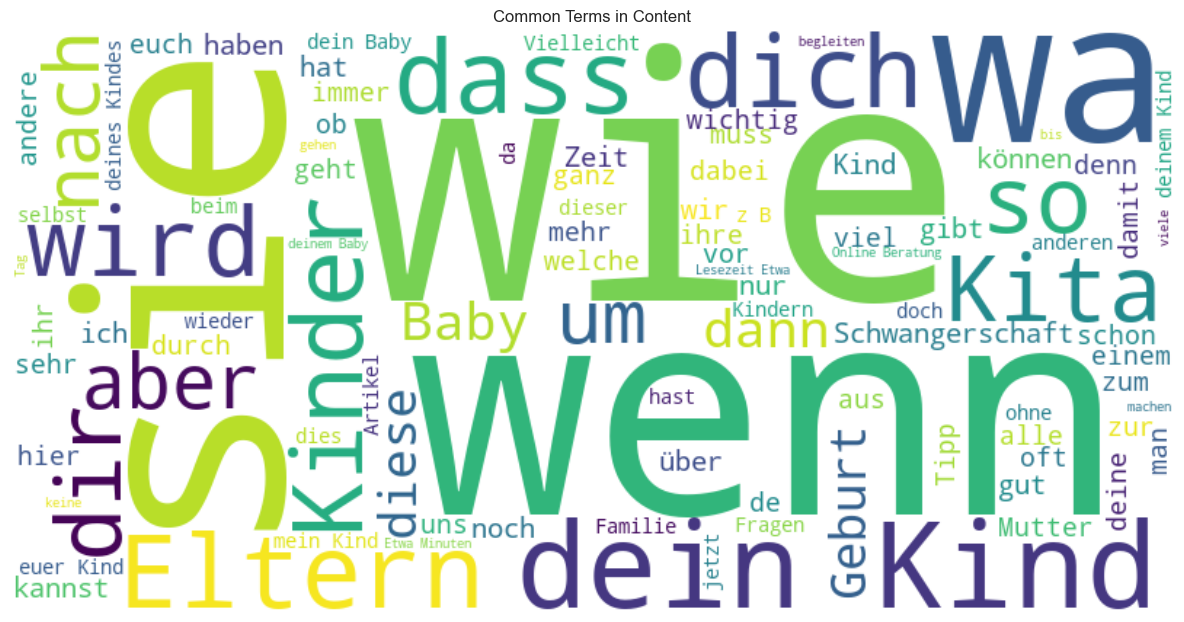

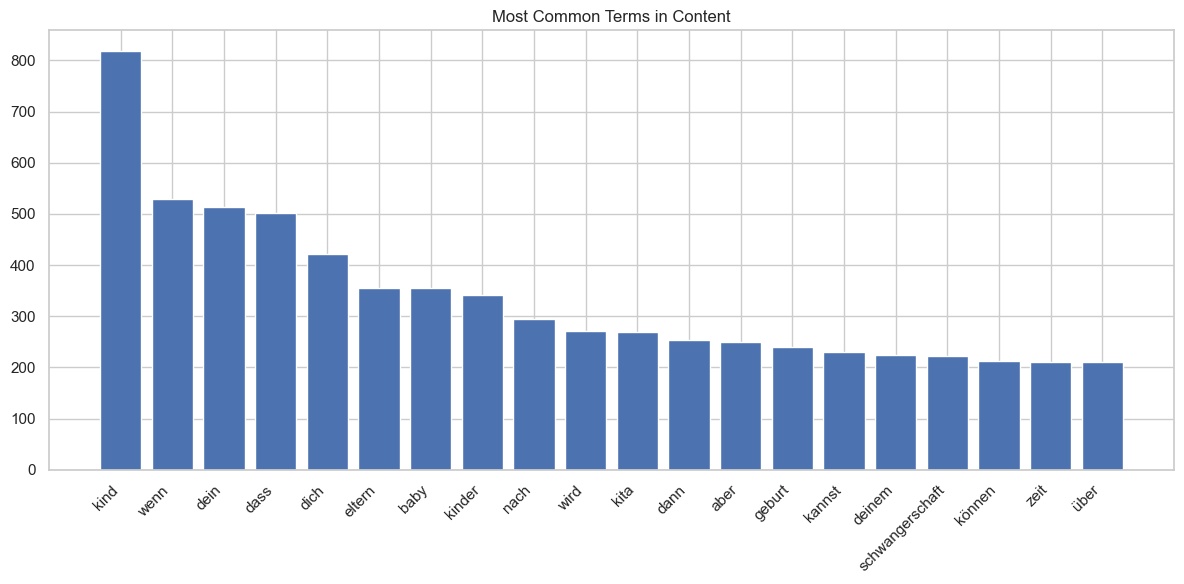

In [37]:
# Function to extract text from markdown
def extract_text_from_md(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            
        # Remove YAML header
        if content.startswith('---'):
            parts = content.split('---', 2)
            if len(parts) >= 3:
                content = parts[2]
        
        # Convert markdown to plain text (via HTML)
        html = markdown(content)
        soup = BeautifulSoup(html, 'html.parser')
        text = soup.get_text()
        
        return text
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return ""

# Sample some content files to analyze
content_dir = 'content'  # Adjust to your actual content directory
sample_files = []

# Find markdown files
for root, dirs, files in os.walk(content_dir):
    for file in files:
        if file.endswith('.md'):
            sample_files.append(os.path.join(root, file))
            if len(sample_files) >= 100:  # Limit sample size
                break
    if len(sample_files) >= 100:
        break

# Extract text from sample files
all_text = ""
for file_path in sample_files:
    all_text += extract_text_from_md(file_path) + " "

# Generate word cloud
stopwords = set(['und', 'der', 'die', 'das', 'mit', 'in', 'für', 'von', 'zu', 'den', 'dem', 'ist', 
                'es', 'ein', 'eine', 'einen', 'einer', 'eines', 'auf', 'sich', 'im', 'du', 'nicht',
                'auch', 'am', 'werden', 'bei', 'sind', 'kann', 'oder', 'an', 'sein', 'als'])

wordcloud = WordCloud(width=800, height=400, background_color='white', 
                     stopwords=stopwords, max_words=100).generate(all_text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Terms in Content')
plt.tight_layout()
plt.show()

# Extract most common terms
words = re.findall(r'\b[a-zA-ZäöüÄÖÜß]{4,}\b', all_text.lower())
word_freq = Counter([w for w in words if w not in stopwords])
common_words = word_freq.most_common(20)

plt.figure(figsize=(12, 6))
plt.bar(*zip(*common_words))
plt.title('Most Common Terms in Content')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5. Conversation Pattern Analysis

Let's analyze the existing conversation patterns to understand user behavior.

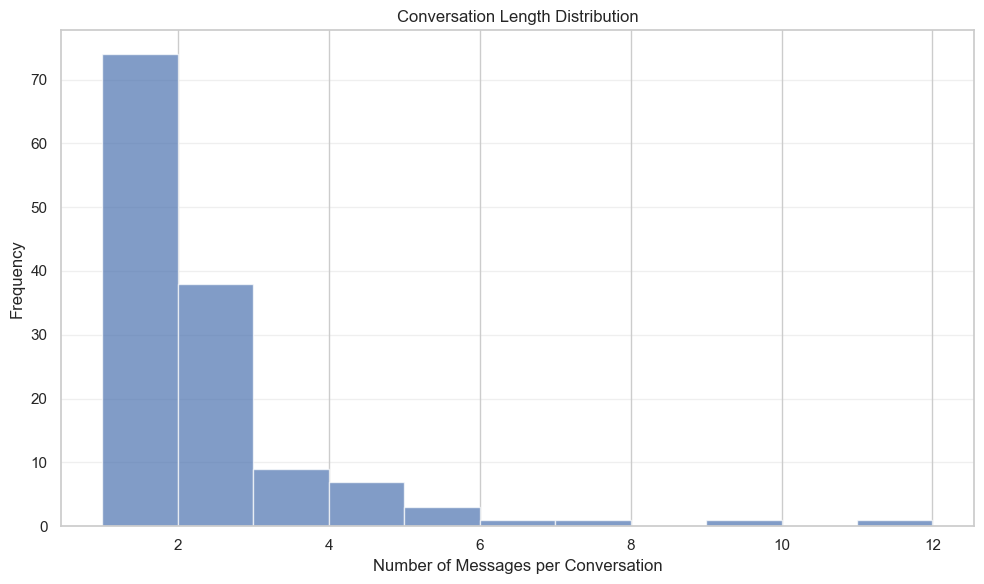

Average messages per conversation: 1.87
Median messages per conversation: 1.0
Longest conversation: 11 messages
Percentage of messages needing escalation: nan%
Number of conversations requiring escalation: 0.0 (0.00%)


IndexError: index 0 is out of bounds for axis 0 with size 0

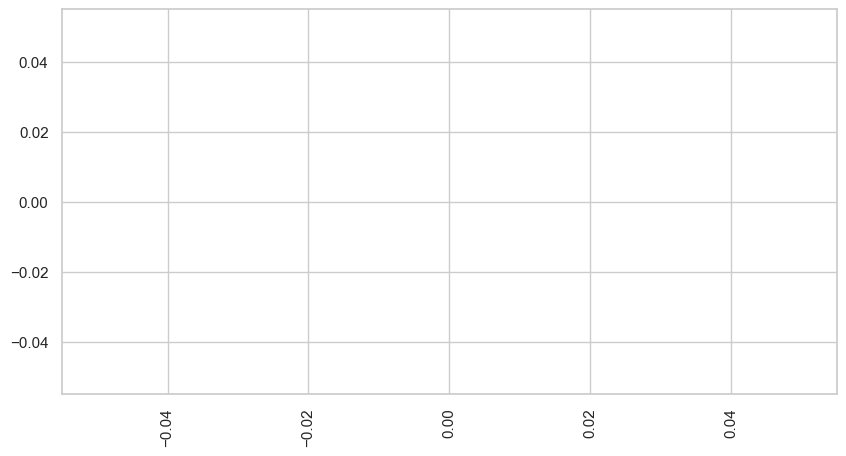

In [38]:
# Analyze conversation length distribution
conv_lengths = conversations_df.groupby('conversation_id').size()

plt.figure(figsize=(10, 6))
plt.hist(conv_lengths, bins=range(1, max(conv_lengths) + 2), alpha=0.7)
plt.title('Conversation Length Distribution')
plt.xlabel('Number of Messages per Conversation')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average messages per conversation: {conv_lengths.mean():.2f}")
print(f"Median messages per conversation: {conv_lengths.median()}")
print(f"Longest conversation: {conv_lengths.max()} messages")

# Analyze conversation escalation
escalation_rate = conversations_df['needs_escalation'].mean()
print(f"Percentage of messages needing escalation: {escalation_rate*100:.2f}%")

# Look at escalation by conversation
conv_escalation = conversations_df.groupby('conversation_id')['needs_escalation'].max()
escalated_convs = conv_escalation.sum()
print(f"Number of conversations requiring escalation: {escalated_convs} ({escalated_convs/len(conv_escalation)*100:.2f}%)")

# Analyze escalation reasons
if 'recommended_approach' in conversations_df.columns:
    approach_counts = conversations_df[conversations_df['needs_escalation'] == 1]['recommended_approach'].value_counts()
    
    plt.figure(figsize=(10, 5))
    approach_counts.plot(kind='bar')
    plt.title('Recommended Approaches for Escalated Conversations')
    plt.xlabel('Approach Code')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Map approach codes to descriptions
    approach_map = {
        1: "Content recommendation",
        2: "Service booking assistance",
        3: "Personalized response",
        4: "Expert consultation" 
    }
    
    for code, count in approach_counts.items():
        if code in approach_map:
            print(f"Approach {int(code)} ({approach_map[int(code)]}): {count} instances")

## 6. User Query Analysis

Let's examine what types of questions users typically ask.

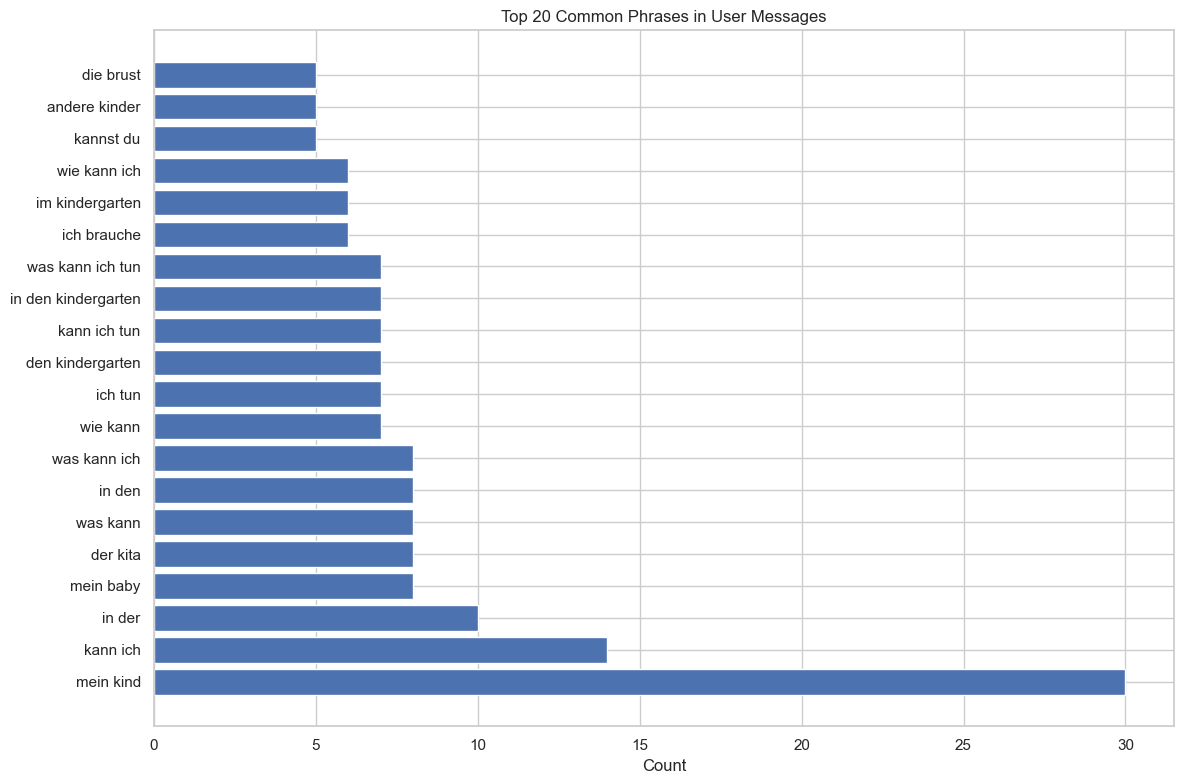

ConversionError: Failed to convert value(s) to axis units: array(['ich', 'Mein Kind', 'Kind'], dtype='<U32')

ConversionError: Failed to convert value(s) to axis units: masked_array(data=[],
             mask=[],
       fill_value=1e+20,
            dtype=float64)

<Figure size 1200x800 with 1 Axes>

In [ ]:
# Extract common phrases from user messages
def extract_common_phrases(text_series, min_count=5, max_words=4):
    """Extract common phrases from a series of text"""
    from collections import Counter
    
    # Preprocessing
    processed_texts = []
    for text in text_series:
        if pd.isna(text):
            continue
        # Convert to lowercase and remove special characters
        text = re.sub(r'[^\w\säöüÄÖÜß]', '', text.lower())
        processed_texts.append(text)
    
    # Extract n-grams (phrases of 2-4 words)
    phrases = []
    for n in range(2, max_words + 1):
        for text in processed_texts:
            words = text.split()
            for i in range(len(words) - n + 1):
                phrase = ' '.join(words[i:i+n])
                phrases.append(phrase)
    
    # Count and filter phrases
    phrase_counts = Counter(phrases)
    common_phrases = {phrase: count for phrase, count in phrase_counts.items() if count >= min_count}
    
    return common_phrases

# Get common phrases from user messages
common_phrases = extract_common_phrases(conversations_df['user_message'], min_count=3)
top_phrases = dict(sorted(common_phrases.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(12, 8))
plt.barh(list(top_phrases.keys()), list(top_phrases.values()))
plt.title('Top 20 Common Phrases in User Messages')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

# Create word cloud of user messages
user_text = ' '.join(conversations_df['user_message'].dropna())
user_wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          stopwords=stopwords, max_words=100).generate(user_text)

plt.figure(figsize=(12, 8))
plt.imshow(user_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Terms in User Messages')
plt.tight_layout()
plt.show()

# Look for question patterns
def categorize_question(text):
    if pd.isna(text):
        return 'unknown'
        
    text_lower = text.lower()
    
    # Yes/no questions
    if any(x in text_lower for x in ['ist es', 'kann ich', 'darf ich', 'soll ich', 'hat jemand']):
        return 'yes_no'
    
    # How questions
    if any(x in text_lower for x in ['wie kann', 'wie soll', 'wie oft', 'wie lange']):
        return 'how_to'
        
    # What questions
    if any(x in text_lower for x in ['was ist', 'was sind', 'was bedeutet', 'was kann']):
        return 'what_is'
        
    # When questions
    if any(x in text_lower for x in ['wann', 'welchem alter']):
        return 'when'
    
    # Why questions
    if any(x in text_lower for x in ['warum', 'wieso']):
        return 'why'
        
    return 'other'

conversations_df['question_type'] = conversations_df['user_message'].apply(categorize_question)
question_counts = conversations_df['question_type'].value_counts()

plt.figure(figsize=(10, 6))
question_counts.plot(kind='bar')
plt.title('Types of Questions Asked by Users')
plt.xlabel('Question Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Identifying Service Connection Points

Let's analyze when and how conversations lead to service opportunities.

Conversations with service-related queries: 6 (4.44%)


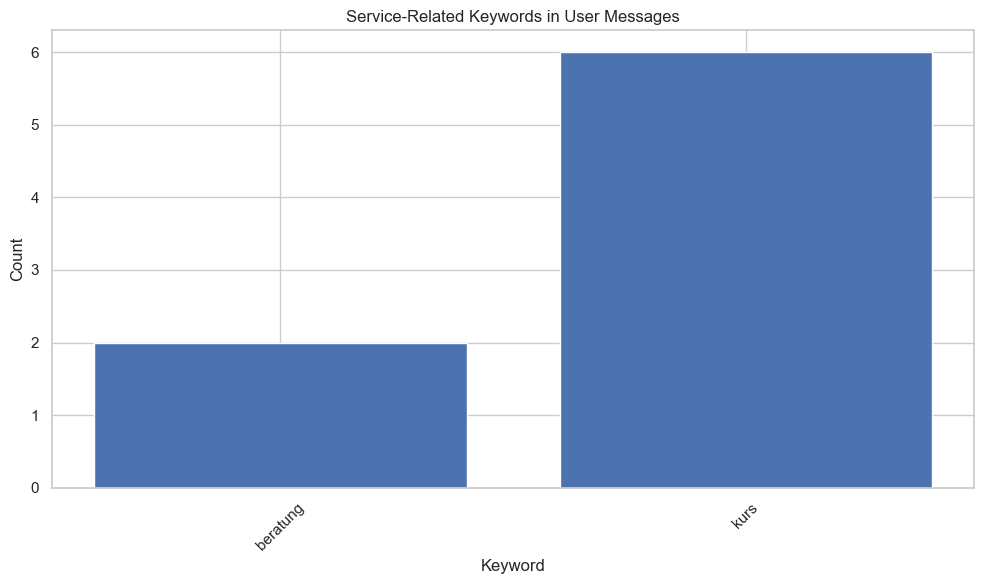

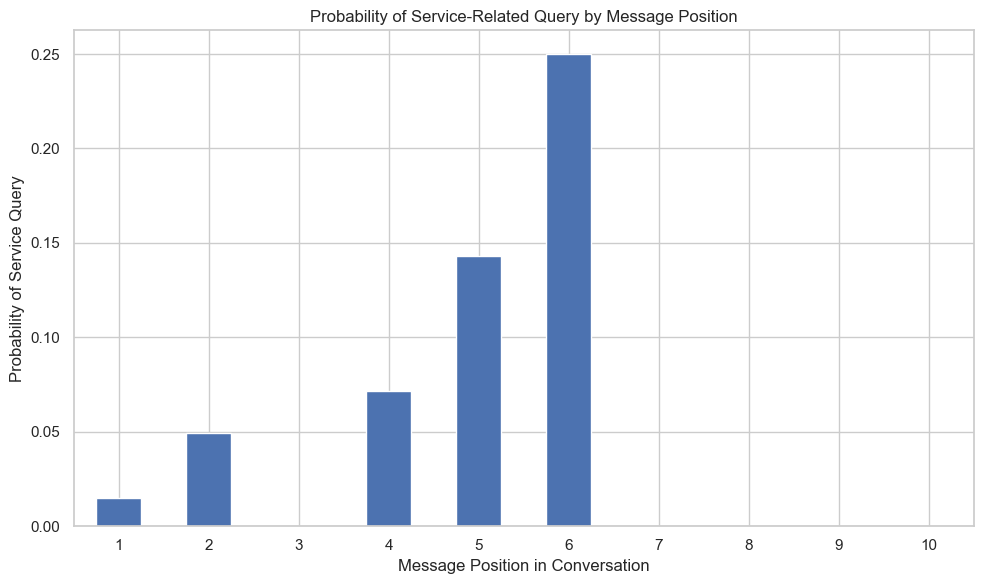

In [21]:
# Identify service-related keywords in conversations
service_keywords = [
    'webinar', 'seminar', 'kurs', 'beratung', 'termin', 'buchen', 
    'anmelden', 'registrieren', 'teilnehmen'
]

def contains_service_keywords(text, keywords=service_keywords):
    if pd.isna(text):
        return False
    text_lower = text.lower()
    return any(keyword in text_lower for keyword in keywords)

conversations_df['service_related'] = conversations_df['user_message'].apply(contains_service_keywords)

# Identify conversations with service-related messages
service_convs = conversations_df.groupby('conversation_id')['service_related'].any()
print(f"Conversations with service-related queries: {service_convs.sum()} ({service_convs.mean()*100:.2f}%)")

# Look at service keywords distribution
service_mentions = []
for text in conversations_df['user_message'].dropna():
    text_lower = text.lower()
    for keyword in service_keywords:
        if keyword in text_lower:
            service_mentions.append(keyword)
            
service_keyword_counts = Counter(service_mentions)

plt.figure(figsize=(10, 6))
plt.bar(service_keyword_counts.keys(), service_keyword_counts.values())
plt.title('Service-Related Keywords in User Messages')
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze when in conversations service queries typically occur
if 'service_related' in conversations_df.columns:
    # Get message position in conversation
    conversations_df['msg_position'] = conversations_df.groupby('conversation_id').cumcount() + 1
    
    # Calculate probability of service query by message position
    service_by_position = conversations_df.groupby('msg_position')['service_related'].mean()
    
    plt.figure(figsize=(10, 6))
    service_by_position[:10].plot(kind='bar')  # First 10 messages
    plt.title('Probability of Service-Related Query by Message Position')
    plt.xlabel('Message Position in Conversation')
    plt.ylabel('Probability of Service Query')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 8. Content-Service Connections

Let's explore which content topics frequently lead to service inquiries.

In [22]:
# Match content references with service inquiries
def extract_urls(text):
    if pd.isna(text):
        return []
    url_pattern = r'https?://[^\s;]+'
    return re.findall(url_pattern, text)

# Extract URLs from chatbot responses
conversations_df['url_list'] = conversations_df['response_links'].apply(extract_urls)
conversations_df = conversations_df.explode('url_list')

# Map URLs to content categories
url_to_category = dict(zip(metadata_df['url'], metadata_df['category']))

# Map URLs in conversations to categories
conversations_df['content_category'] = conversations_df['url_list'].map(url_to_category)

# Find service inquiries following content recommendations
conv_with_urls = conversations_df.dropna(subset=['url_list'])
conv_ids_with_content = set(conv_with_urls['conversation_id'])

# Find category - service connections
category_to_service = {}
for conv_id in conv_ids_with_content:
    conv_data = conversations_df[conversations_df['conversation_id'] == conv_id]
    
    # Get content categories in this conversation
    categories = set(conv_data['content_category'].dropna())
    
    # Check if service inquiry follows
    has_service = any(conv_data['service_related'])
    
    if has_service and categories:
        for category in categories:
            if category not in category_to_service:
                category_to_service[category] = {'count': 0, 'service_count': 0}
            category_to_service[category]['count'] += 1
            category_to_service[category]['service_count'] += 1

# Calculate service conversion rates by category
category_conversion = {
    cat: {'conversion_rate': data['service_count'] / data['count'] * 100, 
          'total': data['count']}
    for cat, data in category_to_service.items()
    if data['count'] >= 5  # Filter for categories with enough data
}

# Sort by conversion rate
sorted_conversions = sorted(category_conversion.items(), 
                           key=lambda x: x[1]['conversion_rate'], 
                           reverse=True)

# Plot conversion rates
if sorted_conversions:
    categories, rates = zip(*[(cat, data['conversion_rate']) 
                            for cat, data in sorted_conversions[:10]])  # Top 10
    
    plt.figure(figsize=(12, 6))
    plt.bar(categories, rates)
    plt.title('Service Conversion Rates by Content Category')
    plt.xlabel('Content Category')
    plt.ylabel('Conversion Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print("Top categories leading to service inquiries:")
    for cat, data in sorted_conversions[:5]:
        print(f"{cat}: {data['conversion_rate']:.1f}% conversion rate ({data['total']} instances)")


## 9. Conversation Time Analysis

Let's analyze when conversations occur and how duration affects outcomes.

/var/folders/p4/p3_vbv2d4db_8b0xhnwthzrh0000gp/T/ipykernel_19366/3259023505.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  conversations_df['request_time'] = pd.to_datetime(conversations_df['request_timestamp'])


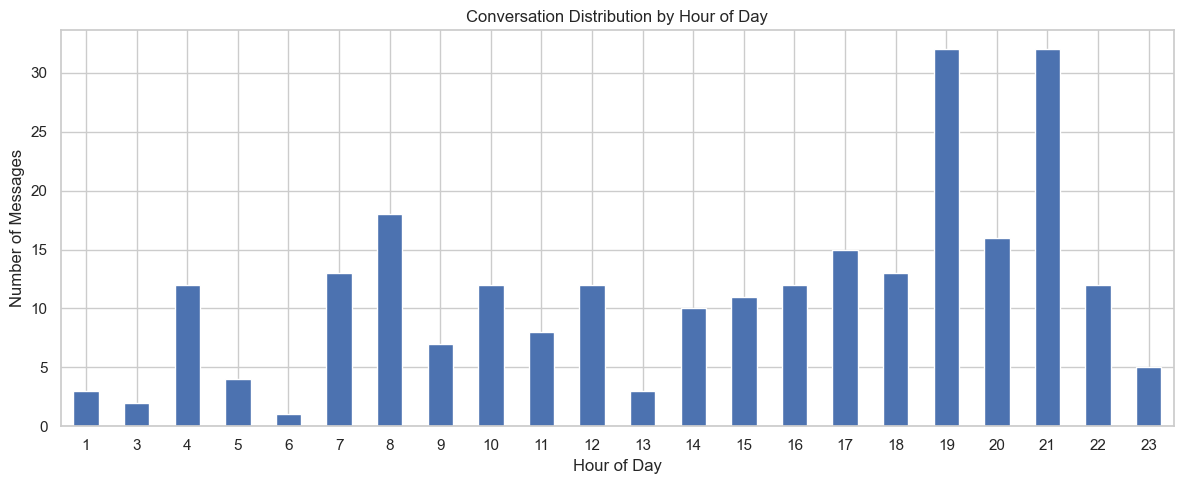

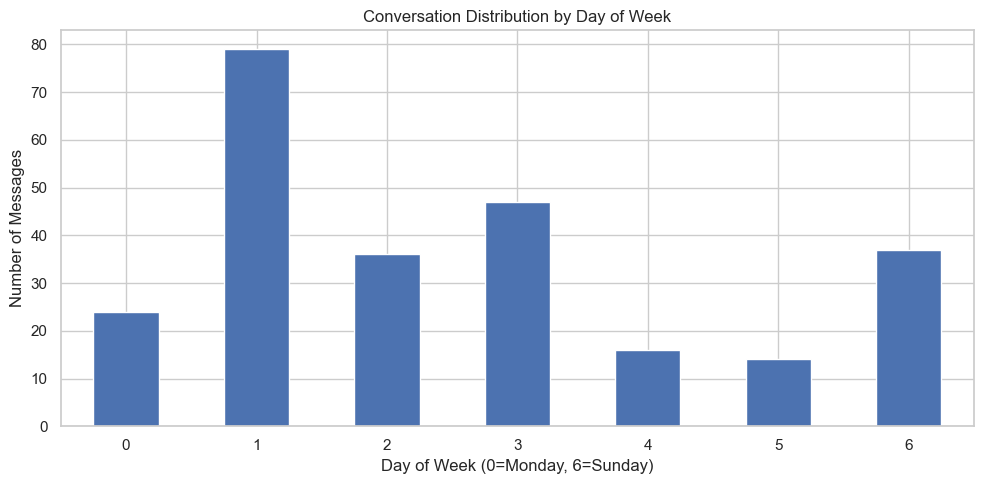

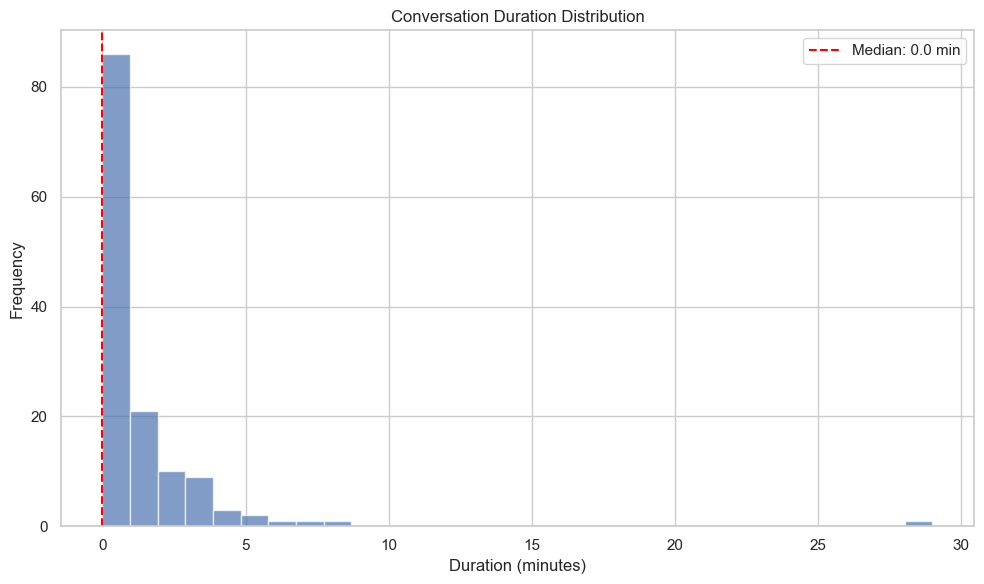

Median conversation duration: 0.0 minutes
Average conversation duration: 1.0 minutes


In [23]:
# Convert timestamps to datetime
conversations_df['request_time'] = pd.to_datetime(conversations_df['request_timestamp'])

# Extract time components
conversations_df['hour'] = conversations_df['request_time'].dt.hour
conversations_df['day_of_week'] = conversations_df['request_time'].dt.dayofweek

# Analyze conversation timing
plt.figure(figsize=(12, 5))
conversations_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Conversation Distribution by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
conversations_df['day_of_week'].value_counts().sort_index().plot(kind='bar')
plt.title('Conversation Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Messages')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate conversation duration
conv_timestamps = conversations_df.groupby('conversation_id').agg({
    'request_time': ['min', 'max']
})
conv_timestamps.columns = ['start_time', 'end_time']
conv_timestamps['duration_minutes'] = (conv_timestamps['end_time'] - conv_timestamps['start_time']).dt.total_seconds() / 60

# Plot conversation duration distribution
plt.figure(figsize=(10, 6))
plt.hist(conv_timestamps['duration_minutes'], bins=30, alpha=0.7)
plt.title('Conversation Duration Distribution')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.axvline(conv_timestamps['duration_minutes'].median(), color='red', linestyle='--', 
           label=f'Median: {conv_timestamps["duration_minutes"].median():.1f} min')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Median conversation duration: {conv_timestamps['duration_minutes'].median():.1f} minutes")
print(f"Average conversation duration: {conv_timestamps['duration_minutes'].mean():.1f} minutes")

## 10. Chatbot Performance Analysis

Finally, let's analyze the performance of the previous chatbot prototype.

Escalated conversations: 0 (0.0%)
Average messages in escalated conversations: nan
Average messages in non-escalated conversations: nan
Average duration of escalated conversations: nan minutes
Average duration of non-escalated conversations: nan minutes


/var/folders/p4/p3_vbv2d4db_8b0xhnwthzrh0000gp/T/ipykernel_19366/1066517947.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([non_esc_duration, esc_duration], labels=['Non-escalated', 'Escalated'])


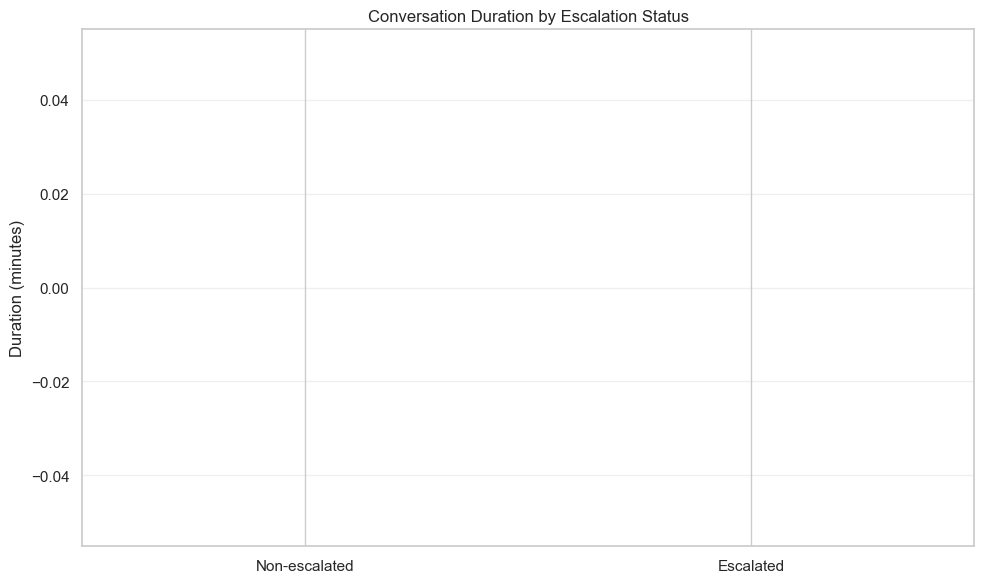

In [24]:
# Analyze escalation patterns
if 'needs_escalation' in conversations_df.columns:
    # Group by conversation
    conv_stats = conversations_df.groupby('conversation_id').agg({
        'needs_escalation': 'max',  # Did conversation need escalation
        'user_message': 'count'     # Number of messages
    })
    
    # Compare escalated vs non-escalated conversations
    escalated = conv_stats[conv_stats['needs_escalation'] == 1]
    non_escalated = conv_stats[conv_stats['needs_escalation'] == 0]
    
    print(f"Escalated conversations: {len(escalated)} ({len(escalated)/len(conv_stats)*100:.1f}%)")
    print(f"Average messages in escalated conversations: {escalated['user_message'].mean():.1f}")
    print(f"Average messages in non-escalated conversations: {non_escalated['user_message'].mean():.1f}")
    
    # Combine with duration data
    conv_stats = conv_stats.join(conv_timestamps['duration_minutes'])
    
    # Compare duration
    esc_duration = conv_stats[conv_stats['needs_escalation'] == 1]['duration_minutes']
    non_esc_duration = conv_stats[conv_stats['needs_escalation'] == 0]['duration_minutes']
    
    print(f"Average duration of escalated conversations: {esc_duration.mean():.1f} minutes")
    print(f"Average duration of non-escalated conversations: {non_esc_duration.mean():.1f} minutes")
    
    # Create box plot comparing the two groups
    plt.figure(figsize=(10, 6))
    plt.boxplot([non_esc_duration, esc_duration], labels=['Non-escalated', 'Escalated'])
    plt.title('Conversation Duration by Escalation Status')
    plt.ylabel('Duration (minutes)')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Conclusion

This exploratory analysis reveals several key insights:

1. **Content Distribution**: The content is organized hierarchically across multiple categories focusing on different child age groups and parenting topics.

2. **Conversation Patterns**: User interactions show specific patterns in length, timing, and topic distribution that can inform the chatbot design.

3. **Service Integration Opportunities**: There are clear patterns showing when users transition from seeking information to inquiring about services.

4. **Escalation Points**: Understanding when previous conversations required human intervention can help design a more robust solution.

Use these insights to guide your approach to building an empathetic, context-aware chatbot that seamlessly integrates with Elternleben.de's service ecosystem.